In [37]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from statistics import mean

In [2]:
df = pd.read_csv('clean_tweets_update.csv', usecols=['tweets', 'pos_lems'])

In [3]:
target_df = pd.read_csv('train.csv', usecols=['target'])
target = list(target_df.target)

In [4]:
print(len(target))

7613


In [5]:
train_df, test_df = df.iloc[:len(target_df), :], df.iloc[len(target_df):, :] 
train_df['target'] = target
train_df.drop_duplicates(subset=['pos_lems'], keep='last', inplace=True)

In [6]:
train_length = len(train_df)
print(train_length)

6851


In [7]:
test_length = len(test_df)
print(test_length)

3263


In [8]:
texts = [train_df.pos_lems, test_df.pos_lems]
tweets = pd.concat(texts)
len(tweets)

10114

In [63]:
train_df.tweets = train_df.tweets.replace('at_user', '')
train_df.tweets = train_df.tweets.replace('url_here', '')

## wordcloud

In [64]:
from wordcloud import WordCloud

def plot_wordcloud (df): 
    pos_ = df[df['target']==1]['tweets']
    neg_ = df[df['target']==0]['tweets']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
    wordcloud1 = WordCloud( background_color='black',
                          width=600,
                          height=400).generate(" ".join(pos_)) 

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Disaster Tweets',color='white',fontsize=40);
    # Non disaster
    wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(neg_)) 

    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Non Disaster Tweets',color='white',fontsize=40);

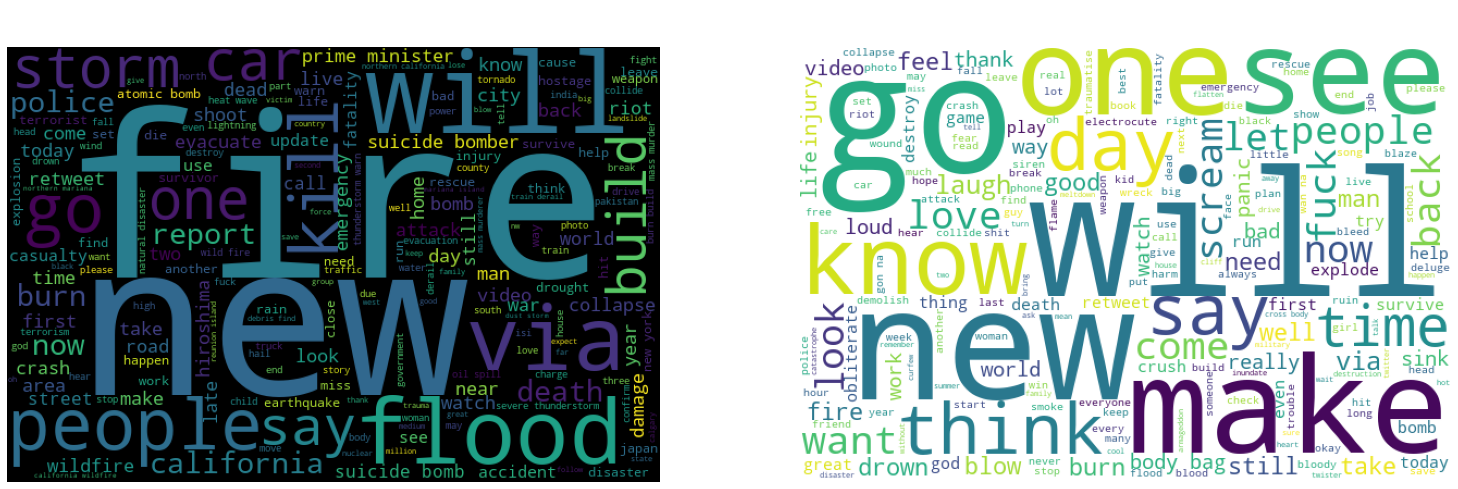

In [65]:
plot_wordcloud(train_df)

# word2vec

In [66]:
def tokenize_text(text):
    tokens = []
    for sent in sent_tokenize(text):
        for word in word_tokenize(sent):
            if len(word)>1:
                tokens.append(word.lower())
    return tokens

In [72]:
tweet_tokens = tweets.apply(tokenize_text)
tweet_tokens = tweet_tokens.replace('at_user', '')
tweet_tokens = tweet_tokens.replace('url_here', '')

In [73]:
word_dict = Counter(tweet_tokens.sum())
# count number of words in corpus
num_words = sum(word_dict[w] for w in word_dict)
print(f'There are {num_words} words in the dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()
vocab_size = len(word_count_sorted)
max_len = max([len(x) for x in tweet_tokens])
print(f'There are {vocab_size} unique words in the dataset')
print("max len of tweets",max_len)
print("min len of tweets",min([len(x) for x in tweet_tokens]))
print("mean len of tweets", mean([len(x) for x in tweet_tokens]))

There are 145322 words in the dataset
There are 13316 unique words in the dataset
max len of tweets 33
min len of tweets 1
mean len of tweets 14.36840023729484


## extract bigrams

In [69]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
#from nltk.corpus import stopwords

In [100]:
def get_documents(text):
    docs = [row.split() for row in text]
    return docs

doc = get_documents(df.tweets)

def sentence_to_bi_grams(sentence):
    return ' '.join(phrases[sentence])

phrases = Phrases(doc, min_count=5, threshold=6, connector_words=ENGLISH_CONNECTOR_WORDS)

frozen_phrases = phrases.freeze()

bigrams = []
for row in doc: 
    parsed_sentence = sentence_to_bi_grams(row)
    bigrams.append(parsed_sentence)


In [101]:
bigrams

['our deed reason this earthquake may allah forgive all',
 'forest_fire near la ronge sask canada',
 'all resident ask shelter place notify by officer no other evacuation or shelter place order expect',
 'people receive wildfire evacuation_order california',
 'just get send this photo from ruby alaska smoke from wildfire pour into school',
 'rocky_fire update california highway close both direction due lake county fire afire wildfire',
 'flood disaster heavy_rain cause flash_flood street manitou colorado spring area',
 'on top hill can_see fire wood',
 'there an emergency evacuation happen now build across street',
 'afraid that tornado come our area',
 'three_people die from heat_wave so_far',
 'haha south tampa get flood hah wait second live south tampa what gon_na do what gon_na do fuck flood',
 'rain flood florida tampa bay tampa or day have lose count',
 'flood bago myanmar we arrive bago',
 'damage school_bus on multi car crash break',
 'what up man',
 'love fruit',
 'summer love

In [77]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction   
import plotly

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly



## uninitialized skipgram

In [78]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [80]:
# uninitializeed model
model_ui_sg = Word2Vec(
        vector_size=50,
        sg=1,
        negative=10,
        sample=1e-3,
        min_count=2,
        epochs=5,
        window=3,
        workers=cores)
vocab = model_ui_sg.build_vocab(tweet_tokens)

model_ui_sg.train(tweet_tokens, total_examples=model_ui_sg.corpus_count, total_words=num_words, compute_loss=True, epochs=5)

(541669, 726610)

In [81]:
model_ui_sg.wv.most_similar(positive="wildfire")

[('northern', 0.9673338532447815),
 ('california', 0.9605915546417236),
 ('raze', 0.9532954096794128),
 ('complex', 0.9176884293556213),
 ('mariana', 0.9165911674499512),
 ('update', 0.9120856523513794),
 ('abc', 0.9067447185516357),
 ('link', 0.9064825773239136),
 ('report', 0.899708092212677),
 ('salt', 0.8953514695167542)]

In [82]:
model_ui_sg.wv.most_similar(positive="earthquake")

[('hawaii', 0.9845123887062073),
 ('volcano', 0.9842666983604431),
 ('alaska', 0.9834550023078918),
 ('sideline', 0.9825984239578247),
 ('jersey', 0.9810552000999451),
 ('turnpike', 0.980180025100708),
 ('coordinate', 0.9799946546554565),
 ('reddits', 0.9798231720924377),
 ('spring', 0.9797874689102173),
 ('financial', 0.9797857999801636)]

In [83]:
model_ui_sg.get_latest_training_loss()

417399.0

In [84]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_sg)
plot_function(x_vals, y_vals, labels)

## self initialized skipgram

In [85]:
# uninitializeed model
model_si_sg = Word2Vec(
        sentences=tweet_tokens,
        vector_size=100,
        sg=0,
        min_count=2,
        epochs=5,
        window=3,
        workers=cores)
vocab = model_si_sg.build_vocab(tweet_tokens)

model_si_sg.train(tweet_tokens, total_examples=model_ui_sg.corpus_count, total_words=num_words, compute_loss=True, epochs=5)

(541753, 726610)

In [86]:
model_si_sg.wv.most_similar(positive="earthquake")

[('park', 0.9960410594940186),
 ('sister', 0.9957026243209839),
 ('eye', 0.9951385855674744),
 ('morning', 0.9950560927391052),
 ('find', 0.9948773384094238),
 ('possible', 0.9943262338638306),
 ('gig', 0.9940447807312012),
 ('cake', 0.9939464926719666),
 ('ruby', 0.9937624931335449),
 ('economy', 0.9937576651573181)]

In [87]:
model_si_sg.wv.most_similar(positive="fire")

[('mariana', 0.9657315015792847),
 ('northern', 0.9636802077293396),
 ('york', 0.9621410369873047),
 ('horse', 0.960506796836853),
 ('raze', 0.9592260718345642),
 ('river', 0.9583818912506104),
 ('abc', 0.956549346446991),
 ('island', 0.955598771572113),
 ('wildfire', 0.9550537467002869),
 ('news', 0.9507284164428711)]

In [88]:
model_si_sg.get_latest_training_loss()

103585.2109375

In [89]:
x_vals, y_vals, labels = reduce_dimensions(model_si_sg)
plot_function(x_vals, y_vals, labels)

# cbow

In [90]:
# uninitializeed model
model_ui_bow = Word2Vec(
        vector_size=100, 
        min_count=2,
        negative=6,
        sample=1e-3,
        window=4, 
        workers=cores)

vocab = model_ui_bow.build_vocab(tweet_tokens)

model_ui_bow.train(tweet_tokens, total_examples=model_ui_bow.corpus_count, epochs=10)

(1083652, 1453220)

In [91]:
model_ui_bow.wv.most_similar(positive="wildfire")

[('northern', 0.985420286655426),
 ('california', 0.969038188457489),
 ('river', 0.9608451128005981),
 ('mariana', 0.9601650238037109),
 ('island', 0.9552378058433533),
 ('hinton', 0.9552146792411804),
 ('interlaken', 0.9495334029197693),
 ('national', 0.9480860829353333),
 ('abc', 0.9480336308479309),
 ('complex', 0.9470967650413513)]

In [92]:
model_ui_bow.wv.most_similar(positive="earthquake")

[('hawaii', 0.9958871603012085),
 ('volcano', 0.9956188797950745),
 ('universal', 0.9944502711296082),
 ('conference', 0.9941272735595703),
 ('utah', 0.9932066202163696),
 ('international', 0.9928812384605408),
 ('sismo', 0.9927613735198975),
 ('coordinate', 0.9925915598869324),
 ('yyc', 0.9924401640892029),
 ('east', 0.9923368096351624)]

In [93]:
model_ui_bow.get_latest_training_loss()

0.0

In [94]:
x_vals, y_vals, labels = reduce_dimensions(model_ui_bow)
plot_function(x_vals, y_vals, labels)

In [ ]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_ui_bow.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['fire']  # Get numpy vector of a word
vector

In [95]:
# self initialized model
model_si_bow = Word2Vec(
        tweet_tokens,
        vector_size=100, 
        cbow_mean=1,
        min_count=2,
        window=2, 
        workers=cores)
vocab = model_si_bow.build_vocab(tweet_tokens)

model_si_bow.train(tweet_tokens,  total_examples=len(tweet_tokens), total_words=num_words, epochs=10)

(1083939, 1453220)

In [96]:
model_si_bow.wv.most_similar(positive="wildfire")

[('northern', 0.9447177052497864),
 ('wild', 0.939266562461853),
 ('marians', 0.9321138262748718),
 ('street', 0.9312609434127808),
 ('complex', 0.930327832698822),
 ('mariana', 0.9219568967819214),
 ('california', 0.9147453308105469),
 ('oil', 0.9136065244674683),
 ('update', 0.9131999611854553),
 ('drought', 0.9113956093788147)]

In [97]:
model_si_bow.wv.most_similar(positive="earthquake")

[('capture', 0.9818170070648193),
 ('indian', 0.9808967113494873),
 ('preview', 0.980315625667572),
 ('hijacker', 0.9777703881263733),
 ('okanagan', 0.9771131873130798),
 ('cape', 0.9763489365577698),
 ('intersection', 0.9761029481887817),
 ('throwback', 0.9759853482246399),
 ('cue', 0.9745391607284546),
 ('law', 0.9744952917098999)]

In [98]:
x_vals, y_vals, labels = reduce_dimensions(model_si_bow)
plot_function(x_vals, y_vals, labels)

In [ ]:
def get_embedding(word, model, vector_size):
    if word in model.wv:
        return model[x]
    else: 
        return np.zeros(vector_size)

def get_average_vector(model, list_of_tweets):    
    vec_dicts = {}
    for tweet in list_of_tweets:
        average_vector = (np.mean(np.array([get_embedding(tweet, model)]), axis=0))
        v_dict = {tweet : (average_vector)}
        vec_dicts.update(v_dict)
        return vec_dicts
    
